In [2]:
from opendp.trans import *
from opendp.meas import *
from opendp.core import *
from opendp.typing import *

# establish data information
data_path = os.path.join('.', 'data', 'PUMS_california_demographics_1000', 'data.csv')
var_names = ["age", "sex", "educ", "race", "income", "married", "pid"]

# TODO: Remove column headers
with open(data_path) as input_data:
    data = input_data.read()


### Privatizing Histograms

Sometimes we will want to release the counts of individual outcomes in a dataset. When plotted, this
makes a histogram. How can we do this in a differentially private way?

In [4]:
preprocessor = (
    # Convert data into Vec<Vec<String>>
    make_split_dataframe(separator=",", col_names=[0, 1, 2, 3, 4]) >>
    # Selects a column of df, Vec<str>
    make_select_column(key=2, T=str) >>
    # Cast the column as Vec<Int>
    make_cast(TI=str, TO=int) >>
    # Impute missing values to 0
    make_impute_constant(0) >>
    make_count_by_categories(categories=list(range(1,20)), MO=L1Distance[float]) # >>
    # make_base_geometric(scale=1., bounds=(0,201), D="VectorDomain<AllDomain<i32>>")
)

# TODO: include this in preprocessor once PR is merged that makes histogram return VectorDomain instead of SizedDomain
res = preprocessor(data)
print("Educational level counts:\n", res)

dp_res = make_base_geometric(scale=1., D=VectorDomain[AllDomain[int]])(res)
print("DP educational level counts:\n", dp_res)


Educational level counts:
 [33, 14, 38, 17, 24, 21, 31, 51, 201, 60, 165, 76, 178, 54, 24, 13, 0, 0, 0, 0]
DP educational level counts:
 [33, 14, 38, 15, 21, 21, 26, 52, 201, 62, 160, 76, 178, 58, 24, 10, -1, 0, 0, -1]


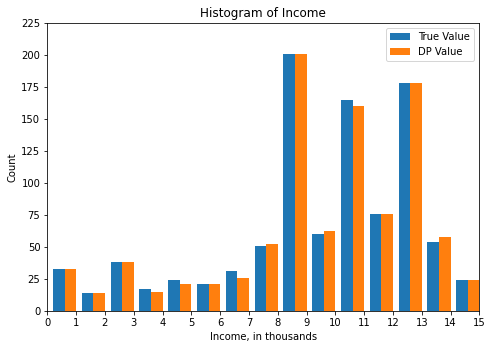

In [25]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

fig = plt.figure()
ax = fig.add_axes([1,1,1,1])
plt.ylim([0,225])
tick_spacing = 1.
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
plt.xlim(0,15)
width = .4

ax.bar(list([x+width for x in range(0, len(res))]), res, width=width, label='True Value')
ax.bar(list([x+2*width for x in range(0, len(dp_res))]), dp_res, width=width, label='DP Value')
ax.legend()
plt.title('Histogram of Income')
plt.xlabel('Income, in thousands')
plt.ylabel('Count')
plt.show()